# Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning

## Case Study: Detecting Intertidal Reefs

#### Daniel Buscombe, MARDA Science

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)

Before you do anything, go to `File > Save copy in Drive` so you can keep and work on your own copy

## Part 3: Train an initial baseline model for detecting intertidal oyster reefs

This jupyter notebook running on Google Colab is part of the "Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning" course. The main course website can be accessed [here](https://mardascience.gitlab.io/binary_image_segmentation_for_geosciences/#/)

In the previous tutorial we made functions to read and pair image and label tiles from this data. In this tutorial, we will start by repeating that process without the visualization steps

Then we will construct, train and evaluate the model. In the [oysterNet paper](https://zslpublications.onlinelibrary.wiley.com/doi/full/10.1002/rse2.134), the authors used a bigger, more sophisticated model for `instance segmentation`, that is, semantic segmentation that is aware of all the different `instances` of the class (i.e. each individual piece of reef). The model they use is called `Mask RCNN`, the implementation of which is [here](https://github.com/matterport/Mask_RCNN). That is a large and very complicated model that is hard to experiment with. The research behind the [oysterNet paper](https://zslpublications.onlinelibrary.wiley.com/doi/full/10.1002/rse2.134) is state-of-the-art.

Here, we use a simpler model with fewer parameters (namely, a residual UNet) and acheive acceptable results for a semantic segmentation (predicting the masks of where the reefs are, rather than by individual instances). The UNet is the same we used in a [previous set of tutorials](https://mardascience.gitlab.io/deep_learning_landscape_classification/#/) and is relatively simple to adapt and play with to demonstrate a few principles.

**Actually, in this tutorial we'll start with a basic implementation and get bad results (!) This is on purpose. It demonstrates what you would expect by using an inappropriate loss function for a class imbalanced problem. Class imbalance is probably the norm for binary segmentations, so it's something you need to pay attention to**

Then in the next parts, we'll adapt our training strategies and try different variations of the model, converging toward a more satisfactory result

This is designed to demonstrate a problem-solving strategy, and also a principle that often applies to natural imagery:

> It's not just the model you choose, it's how you train it that counts

### Import libraries

In [0]:
import os #for accessing operating system utilities
from glob import glob #for finding files that match a certain string pattern
import matplotlib.pyplot as plt #for plotting
import numpy as np #for numerical operations
import random, string #for creating random strings
import tensorflow as tf #tensorflow
import json # for reading lable annotations in json format
import requests #for downloading files 
from PIL import Image, ImageFilter #for reading and filtering imagery
import skimage.draw #for making masks (raster label images) from label annotations
from skimage.transform import resize #for resizing imagery
from psutil import virtual_memory #for interrogating our filesystem and RAM specifications
from imageio import imwrite

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from random import shuffle
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, Conv2DTranspose, Flatten, Activation, Add
from tensorflow.keras.models import Model

### Prepare the data

#### Download the  imagery


For the remainder of the tutorials, we'll be using this version of the data, consisting of imagery and image labels, with an augmented training set consisting of double the original number of imagery, half of which have been augmented with random flips, zoms and rotations

In [0]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """
    response = filename for input
    destination = filename for output
    """    
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [0]:
file_id = '19RgkzaD9w-rvAF9uBpqMONnwF0lJVPh3'
destination = 'train_images.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf train_images.tar.gz > tmp.txt

In [0]:
file_id = '1gjWGXO7mtBhJuSOqrG6B1inzLF8TfTSX'
destination = 'val_images.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf val_images.tar.gz > tmp.txt

In [0]:
file_id = '1x8HrgEStkBCdBmFNo1xa0x6LCVE2GE1g'
destination = 'train_labels.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf train_labels.tar.gz > tmp.txt

In [0]:
file_id = '1v0kPgwZVQNrGAk0awJi31W83CYvHJbeX'
destination = 'val_labels.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf val_labels.tar.gz > tmp.txt

In [0]:
root = './content/'

Check to see how many images we now have to work with

In [0]:
train_files = glob(root+"1kx1k_dataset/train_images/data/*.png")
val_files = glob(root+"1kx1k_dataset/val_images/data/*.png")

print("# train files: %i" % (len(train_files)))
print("# validation files: %i" % (len(val_files)))

# train files: 1054
# validation files: 130


### Setting up model training

#### Custom batch generator

We are going to feed images to the network in batches. The batch size (number of images and associated labels) will be ...

In [0]:
batch_size = 6

The next function is an image batch generator. A `generator` is a special type of python function that `yields` a set of data. In our case, it will yield a set of `batch_size` images and labels drawn randomly from the entire set of `files` provided

It opens the file, reads it into a numpy array with correct dimensions checked, and then does the same for the label image. It scales the image by dividing by 255, do turn the 8-bit data scaled between 0 and 255 to data scaled between 0 and 1. The labels are flattened from 3D (RGB) to 2D (greyscale integers)

In [0]:
def image_batch_generator(files, sz, batch_size = 4):

  while True: # this is here because it will be called repeatedly by the training function

    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)

    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []

    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images
        raw = Image.open(f)
        raw = raw.resize(sz)
        raw = raw.filter(ImageFilter.UnsharpMask(radius=20, percent=100))
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]

        #get the image dimensions, find the min dimension, then square the image off
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:]

        raw[np.isnan(raw)] = 1e-5 #make any NaNs and InFs a very small number
        raw[np.isinf(raw)] = 1e-5

        batch_x.append(raw)

        #get the masks.
        maskfile = f.replace('_images','_labels').replace('.png','.jpg')
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        try:
           mask = np.max(np.array(mask.resize(sz)),axis=2)
        except:
           mask = np.array(mask.resize(sz))

        # water pixels are always greater than 170
        mask = (mask>170).astype('int') ##170 = (2/3)*255

        mask = mask[:n,:n]

        mask[np.isnan(mask)] = 1e-5
        mask[np.isinf(mask)] = 1e-5
        batch_y.append(mask)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x) #/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,1) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

Let's test our generator function

We will specify input imagery of size `(512, 512, 3)`

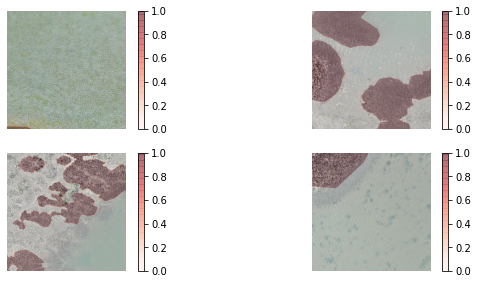

In [0]:
sz = (512, 512)

gen = image_batch_generator(train_files, sz, batch_size = 4)

images, masks = next(gen)

plt.figure(figsize=(10,10))

for k in range(len(images)):
  plt.subplot(4,2, k+1)
  plt.imshow(images[k])
  plt.imshow(masks[k].squeeze(), vmin=0, vmax=1, alpha=0.25, cmap=plt.cm.Reds)
  plt.colorbar()
  plt.axis('off')

#### Build the model

The following definitions are used to make the residual UNet model, which is what we will be using for our binary segmentation

In [0]:
def batchnorm_act(x):
    x = BatchNormalization()(x)
    return Activation("relu")(x)

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batchnorm_act(x)
    return Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)

def bottleneck_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([conv, bottleneck])

def res_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([bottleneck, res])

def upsamp_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    return Concatenate()([u, xskip])

def res_unet(sz, f):
    inputs = Input(sz)
    
    ## downsample  
    e1 = bottleneck_block(inputs, f); f = int(f*2)
    e2 = res_block(e1, f, strides=2); f = int(f*2)
    e3 = res_block(e2, f, strides=2); f = int(f*2)
    e4 = res_block(e3, f, strides=2); f = int(f*2)
    _ = res_block(e4, f, strides=2)
    
    ## bottleneck
    b0 = conv_block(_, f, strides=1)
    _ = conv_block(b0, f, strides=1)
    
    ## upsample
    _ = upsamp_concat_block(_, e4)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e3)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e2)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e1)
    _ = res_block(_, f)
    
    ## classify
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(_)
    
    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
	

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$L = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

We use `binary_crossentropy` as the loss function. It is defined:

$$L = \sum{y_{pred}\log(y_{true}) + (1- y_{pred}) \log(1 -y_{true})}$$


In [0]:
model = res_unet(sz+(3,), batch_size)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [mean_iou])

Let's take a look at how many parameters we have to optimize

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 6)  168         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 6)  24          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 6)  24          input_1[0][0]                    
______________________________________________________________________________________________

We have over 600,000 trainable parameters. This is a lot, for any model, but tiny compared to the number of parameters in some deep learning models, with up to hundreds of millions of trainable parameters

### Train the model

We can use a custom callback function to see how the model is training while it trains

This must be placed within a class with only one input, `tf.keras.callbacks.Callback`. 

See https://www.tensorflow.org/guide/keras/custom_callback for more details

The following will create a plot, at the end of each training epoch, of the segmentation of one validation image using the current state of the model, while it trains

The plot consists of three images side by side: the validation image, the predicted binary mask, and the masked image showing just that class

The internal function `on_train_begin` allocates some empty lists that are subsequently filled at the end of the epoch, when `on_epoch_end` is called

In [0]:
callbacks = tf.keras.callbacks
backend = tf.keras.backend


class PlotLearning(callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))

        #choose a random test image and preprocess
        f = np.random.choice(val_files)

        raw = np.array(Image.open(f).resize(sz))

        #predict the mask
        pred = 255*model.predict(np.expand_dims(raw, 0)).squeeze()
        print(np.max(pred))

        #mask post-processing
        msk  = (pred>200).astype('int') 

        msk = np.stack((msk,)*3, axis=-1)

        #show the mask and the segmented image
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()
        #plt.savefig(str(self.i)+'.png', dpi=100, bbox_inches='tight')

These are parameters that we will pass to callback functions that will adaptively change the pace of training (using an adaptive learning rate), and decide when there is little to be gained from extra training (called 'early stopping')

Reduce loss on plateau: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

Early stopping: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

We'll see that even though the `max_epochs` is set to 100, the model won't need that many epochs


In [0]:
# a tolerance for the training. 
min_delta = 0.0001

# minimum learning rate (lambda)
min_lr = 0.0001

# the factor applied to the learning rate when the appropriate triggers are made
factor = 0.2

# number of epochs without performance improvement before the learning rate is adjusted
# and number of epochs with no improvement after which training will be stopped.
patience=25

#number of epochs to wait before resuming normal operation after the learning rate has been reduced.
cooldown=2

max_epochs = 100

Now we have defined all these hyperparameters (parameters that we chose, not automatically determined by the model), we can make a function that builds all the various callbacks together into a list, which can then be passed to the model training (`.fit()` function)

In [0]:
def build_callbacks(filepath, min_delta, min_lr, factor, patience, cooldown):

    earlystop = EarlyStopping(monitor="val_loss", 
                                  mode="min", patience=patience) 
    
    # reduction of learning rate if and when validation scores plateau upon successive epochs
    reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, 
                                    verbose=1, mode='auto', min_delta=min_delta, 
                                    cooldown=cooldown, min_lr=min_lr)

    # set checkpoint file 
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                   verbose=0, save_best_only=True, mode='min', 
                                   save_weights_only = True)
        
    callbacks = [model_checkpoint, reduceloss_plat, earlystop, PlotLearning()]

    return callbacks 

Next, set up a name for the `.h5` file that will be used to store model weights.

Finally, we train the model by calling the `.fit()` command and providing all the generators and hyperparameters defined in the callbacks

The number of training and validation steps is simply the number of respective files divided by the batch size

In [0]:
filepath = 'reefs_test_weights_uresnet'+str(batch_size)+'_'+str(max_epochs)+'epochs_iou.h5'

train_generator = image_batch_generator(train_files, sz, batch_size = batch_size)
val_generator  = image_batch_generator(val_files, sz, batch_size = batch_size)
train_steps = len(train_files) //batch_size
val_steps = len(val_files) //batch_size
print(train_steps)
print(val_steps)

175
21


Train the model

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 0.4106 - mean_iou: 0.0125i= 1 loss= 0.410634309053421 val_loss= 0.3789593577384949 mean_iou= 0.012453555129468441 val_mean_iou= 5.846595740877092e-05
93.324066


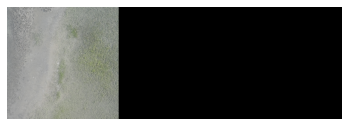

175/175 [==============================] - 139s 793ms/step - loss: 0.4106 - mean_iou: 0.0125 - val_loss: 0.3790 - val_mean_iou: 5.8466e-05 - lr: 0.0010
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 0.3888 - mean_iou: 0.0062i= 2 loss= 0.388764351606369 val_loss= 0.4099433124065399 mean_iou= 0.006160157732665539 val_mean_iou= 0.00015449761121999472
90.25824


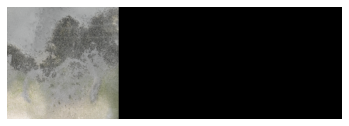

175/175 [==============================] - 134s 766ms/step - loss: 0.3888 - mean_iou: 0.0062 - val_loss: 0.4099 - val_mean_iou: 1.5450e-04 - lr: 0.0010
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 0.3908 - mean_iou: 0.0118i= 3 loss= 0.39081063866615295 val_loss= 0.3118019104003906 mean_iou= 0.011820778250694275 val_mean_iou= 0.0
63.909058


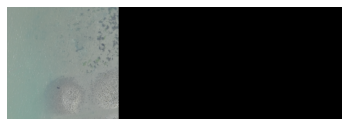

175/175 [==============================] - 131s 751ms/step - loss: 0.3908 - mean_iou: 0.0118 - val_loss: 0.3118 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 0.3761 - mean_iou: 0.0229i= 4 loss= 0.3761283755302429 val_loss= 0.4527895450592041 mean_iou= 0.022903788834810257 val_mean_iou= 1.854275615187362e-05
65.25195


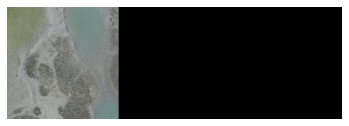

175/175 [==============================] - 132s 753ms/step - loss: 0.3761 - mean_iou: 0.0229 - val_loss: 0.4528 - val_mean_iou: 1.8543e-05 - lr: 0.0010
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 0.3864 - mean_iou: 0.0115i= 5 loss= 0.3864196538925171 val_loss= 0.3489679992198944 mean_iou= 0.01149143185466528 val_mean_iou= 1.59621504280949e-05
60.05119


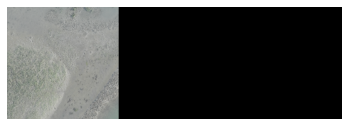

175/175 [==============================] - 131s 746ms/step - loss: 0.3864 - mean_iou: 0.0115 - val_loss: 0.3490 - val_mean_iou: 1.5962e-05 - lr: 0.0010
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 0.3694 - mean_iou: 0.0057i= 6 loss= 0.3694239854812622 val_loss= 0.32221853733062744 mean_iou= 0.0057483636774122715 val_mean_iou= 0.0476190485060215
58.448376


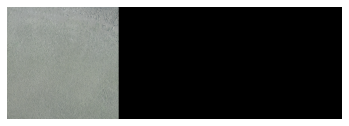

175/175 [==============================] - 130s 741ms/step - loss: 0.3694 - mean_iou: 0.0057 - val_loss: 0.3222 - val_mean_iou: 0.0476 - lr: 0.0010
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 0.3735 - mean_iou: 1.4389e-04i= 7 loss= 0.37354639172554016 val_loss= 0.36325567960739136 mean_iou= 0.00014389284478966147 val_mean_iou= 0.0
54.284786


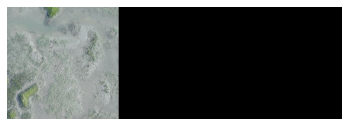

175/175 [==============================] - 130s 741ms/step - loss: 0.3735 - mean_iou: 1.4389e-04 - val_loss: 0.3633 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 0.3666 - mean_iou: 0.0117i= 8 loss= 0.36664003133773804 val_loss= 0.36271539330482483 mean_iou= 0.011676518246531487 val_mean_iou= 9.333482012152672e-05
50.6727


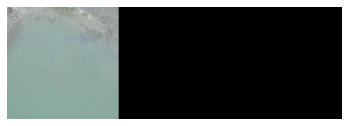

175/175 [==============================] - 130s 740ms/step - loss: 0.3666 - mean_iou: 0.0117 - val_loss: 0.3627 - val_mean_iou: 9.3335e-05 - lr: 0.0010
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 0.3790 - mean_iou: 0.0173i= 9 loss= 0.378991961479187 val_loss= 0.426139771938324 mean_iou= 0.017321784049272537 val_mean_iou= 0.047735895961523056
92.34617


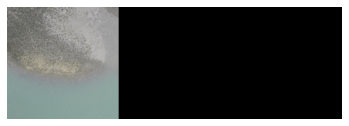

175/175 [==============================] - 130s 742ms/step - loss: 0.3790 - mean_iou: 0.0173 - val_loss: 0.4261 - val_mean_iou: 0.0477 - lr: 0.0010
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 0.3736 - mean_iou: 0.0229i= 10 loss= 0.37357771396636963 val_loss= 0.36514976620674133 mean_iou= 0.022857142612338066 val_mean_iou= 1.0866041520785075e-05
74.93385


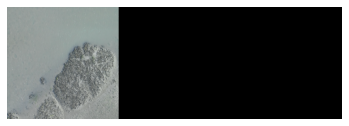

175/175 [==============================] - 131s 747ms/step - loss: 0.3736 - mean_iou: 0.0229 - val_loss: 0.3651 - val_mean_iou: 1.0866e-05 - lr: 0.0010
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 0.3806 - mean_iou: 0.0229i= 11 loss= 0.38064107298851013 val_loss= 0.31004878878593445 mean_iou= 0.022857725620269775 val_mean_iou= 6.397234756150283e-06
54.16793


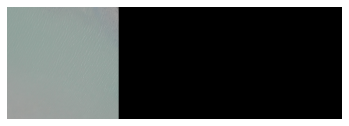

175/175 [==============================] - 128s 731ms/step - loss: 0.3806 - mean_iou: 0.0229 - val_loss: 0.3100 - val_mean_iou: 6.3972e-06 - lr: 0.0010
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 0.3673 - mean_iou: 0.0400i= 12 loss= 0.367342472076416 val_loss= 0.33624008297920227 mean_iou= 0.04004151374101639 val_mean_iou= 5.419927219918463e-06
65.67801


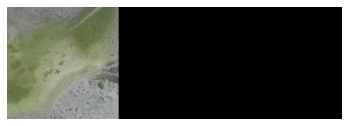

175/175 [==============================] - 129s 739ms/step - loss: 0.3673 - mean_iou: 0.0400 - val_loss: 0.3362 - val_mean_iou: 5.4199e-06 - lr: 0.0010
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 0.3727 - mean_iou: 0.0115i= 13 loss= 0.3727480471134186 val_loss= 0.35584700107574463 mean_iou= 0.011475800536572933 val_mean_iou= 0.037044137716293335
53.361744


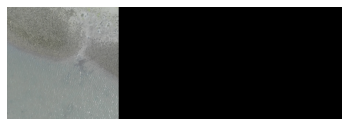

175/175 [==============================] - 129s 738ms/step - loss: 0.3727 - mean_iou: 0.0115 - val_loss: 0.3558 - val_mean_iou: 0.0370 - lr: 0.0010
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 0.3637 - mean_iou: 0.0344i= 14 loss= 0.36369988322257996 val_loss= 0.35179248452186584 mean_iou= 0.034371890127658844 val_mean_iou= 0.0027052918449044228
54.450294


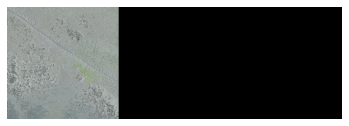

175/175 [==============================] - 130s 743ms/step - loss: 0.3637 - mean_iou: 0.0344 - val_loss: 0.3518 - val_mean_iou: 0.0027 - lr: 0.0010
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 0.3611 - mean_iou: 0.0229i= 15 loss= 0.3610799014568329 val_loss= 0.37042978405952454 mean_iou= 0.022857334464788437 val_mean_iou= 0.011458570137619972
47.424076


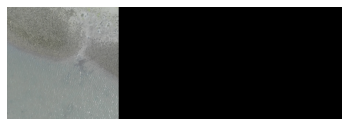

175/175 [==============================] - 129s 736ms/step - loss: 0.3611 - mean_iou: 0.0229 - val_loss: 0.3704 - val_mean_iou: 0.0115 - lr: 0.0010
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 0.3795 - mean_iou: 0.0114i= 16 loss= 0.37950465083122253 val_loss= 0.3411716818809509 mean_iou= 0.011431876569986343 val_mean_iou= 0.0
50.923313


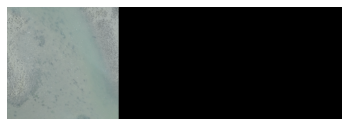

175/175 [==============================] - 128s 734ms/step - loss: 0.3795 - mean_iou: 0.0114 - val_loss: 0.3412 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 0.3672 - mean_iou: 0.0172i= 17 loss= 0.36715683341026306 val_loss= 0.37743207812309265 mean_iou= 0.017244353890419006 val_mean_iou= 0.046824973076581955
161.07372


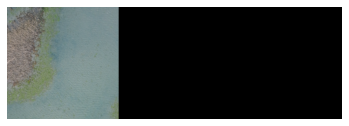

175/175 [==============================] - 129s 734ms/step - loss: 0.3672 - mean_iou: 0.0172 - val_loss: 0.3774 - val_mean_iou: 0.0468 - lr: 0.0010
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 0.3726 - mean_iou: 0.0234i= 18 loss= 0.37261226773262024 val_loss= 0.3540801703929901 mean_iou= 0.023396819829940796 val_mean_iou= 0.047645773738622665
45.6542


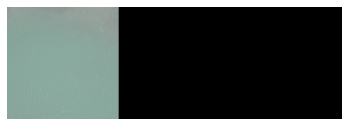

175/175 [==============================] - 128s 732ms/step - loss: 0.3726 - mean_iou: 0.0234 - val_loss: 0.3541 - val_mean_iou: 0.0476 - lr: 0.0010
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 0.3703 - mean_iou: 0.0057i= 19 loss= 0.3703429400920868 val_loss= 0.3082980513572693 mean_iou= 0.005743643268942833 val_mean_iou= 0.0
73.077255


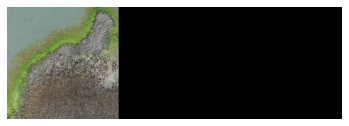

175/175 [==============================] - 129s 735ms/step - loss: 0.3703 - mean_iou: 0.0057 - val_loss: 0.3083 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 0.3588 - mean_iou: 7.2400e-06i= 20 loss= 0.3588370978832245 val_loss= 0.28222548961639404 mean_iou= 7.239982551254798e-06 val_mean_iou= 0.0
48.85523


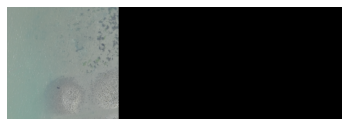

175/175 [==============================] - 129s 736ms/step - loss: 0.3588 - mean_iou: 7.2400e-06 - val_loss: 0.2822 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 0.3718 - mean_iou: 0.0286i= 21 loss= 0.3718291223049164 val_loss= 0.3473224639892578 mean_iou= 0.02857959270477295 val_mean_iou= 0.0
48.952644


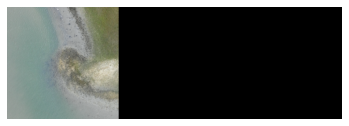

175/175 [==============================] - 128s 733ms/step - loss: 0.3718 - mean_iou: 0.0286 - val_loss: 0.3473 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 0.3755 - mean_iou: 0.0114i= 22 loss= 0.3755400776863098 val_loss= 0.3641907572746277 mean_iou= 0.011428623460233212 val_mean_iou= 0.0
93.83749


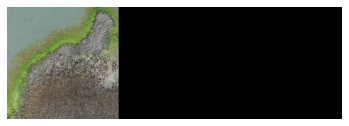

175/175 [==============================] - 129s 739ms/step - loss: 0.3755 - mean_iou: 0.0114 - val_loss: 0.3642 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 23/200
175/175 [==============================] - ETA: 0s - loss: 0.3614 - mean_iou: 0.0116i= 23 loss= 0.3614327907562256 val_loss= 0.34991660714149475 mean_iou= 0.01160391978919506 val_mean_iou= 0.0
51.347263


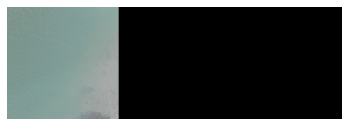

175/175 [==============================] - 129s 738ms/step - loss: 0.3614 - mean_iou: 0.0116 - val_loss: 0.3499 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 24/200
175/175 [==============================] - ETA: 0s - loss: 0.3698 - mean_iou: 0.0173i= 24 loss= 0.36976033449172974 val_loss= 0.3512321412563324 mean_iou= 0.017311984673142433 val_mean_iou= 0.00011023644037777558
68.88274


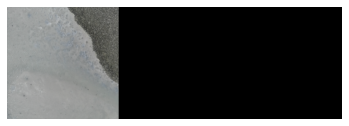

175/175 [==============================] - 129s 738ms/step - loss: 0.3698 - mean_iou: 0.0173 - val_loss: 0.3512 - val_mean_iou: 1.1024e-04 - lr: 0.0010
Epoch 25/200
175/175 [==============================] - ETA: 0s - loss: 0.3654 - mean_iou: 0.0229i= 25 loss= 0.3653664290904999 val_loss= 0.32958486676216125 mean_iou= 0.022857142612338066 val_mean_iou= 0.0
46.195793


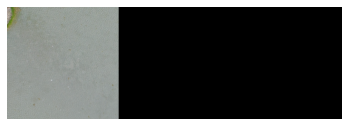

175/175 [==============================] - 128s 734ms/step - loss: 0.3654 - mean_iou: 0.0229 - val_loss: 0.3296 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 26/200
175/175 [==============================] - ETA: 0s - loss: 0.3644 - mean_iou: 0.0343i= 26 loss= 0.3644190728664398 val_loss= 0.3565344214439392 mean_iou= 0.034305211156606674 val_mean_iou= 0.0476190485060215
46.971817


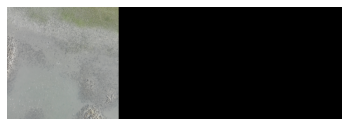

175/175 [==============================] - 128s 732ms/step - loss: 0.3644 - mean_iou: 0.0343 - val_loss: 0.3565 - val_mean_iou: 0.0476 - lr: 0.0010
Epoch 27/200
175/175 [==============================] - ETA: 0s - loss: 0.3675 - mean_iou: 0.0114i= 27 loss= 0.3675132095813751 val_loss= 0.3179958760738373 mean_iou= 0.011428571306169033 val_mean_iou= 0.0038895905017852783
79.39676


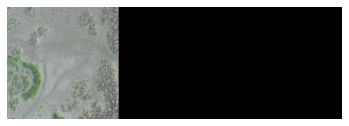

175/175 [==============================] - 128s 732ms/step - loss: 0.3675 - mean_iou: 0.0114 - val_loss: 0.3180 - val_mean_iou: 0.0039 - lr: 0.0010
Epoch 28/200
175/175 [==============================] - ETA: 0s - loss: 0.3781 - mean_iou: 0.0171i= 28 loss= 0.37812405824661255 val_loss= 0.3357763886451721 mean_iou= 0.01714290678501129 val_mean_iou= 0.007195270620286465
68.19303


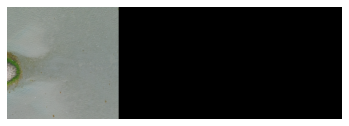

175/175 [==============================] - 130s 740ms/step - loss: 0.3781 - mean_iou: 0.0171 - val_loss: 0.3358 - val_mean_iou: 0.0072 - lr: 0.0010
Epoch 29/200
175/175 [==============================] - ETA: 0s - loss: 0.3663 - mean_iou: 0.0343i= 29 loss= 0.36630910634994507 val_loss= 0.34049639105796814 mean_iou= 0.034285712987184525 val_mean_iou= 0.0
44.632977


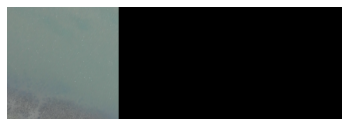

175/175 [==============================] - 129s 739ms/step - loss: 0.3663 - mean_iou: 0.0343 - val_loss: 0.3405 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 30/200
175/175 [==============================] - ETA: 0s - loss: 0.3606 - mean_iou: 0.0343i= 30 loss= 0.360646516084671 val_loss= 0.32055121660232544 mean_iou= 0.03429581597447395 val_mean_iou= 0.0020088511519134045
45.988483


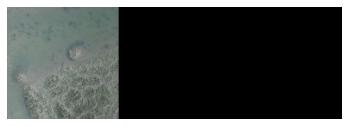

175/175 [==============================] - 132s 754ms/step - loss: 0.3606 - mean_iou: 0.0343 - val_loss: 0.3206 - val_mean_iou: 0.0020 - lr: 0.0010
Epoch 31/200
175/175 [==============================] - ETA: 0s - loss: 0.3738 - mean_iou: 0.0114i= 31 loss= 0.3738443851470947 val_loss= 0.31170129776000977 mean_iou= 0.011428571306169033 val_mean_iou= 0.0
42.700764


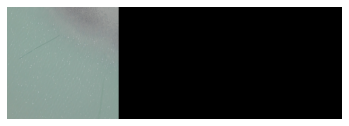

175/175 [==============================] - 130s 743ms/step - loss: 0.3738 - mean_iou: 0.0114 - val_loss: 0.3117 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 32/200
175/175 [==============================] - ETA: 0s - loss: 0.3638 - mean_iou: 0.0115i= 32 loss= 0.3637671172618866 val_loss= 0.34708765149116516 mean_iou= 0.011484467424452305 val_mean_iou= 0.0
57.929012


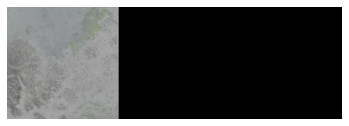

175/175 [==============================] - 135s 769ms/step - loss: 0.3638 - mean_iou: 0.0115 - val_loss: 0.3471 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 33/200
175/175 [==============================] - ETA: 0s - loss: 0.3668 - mean_iou: 0.0114i= 33 loss= 0.36677664518356323 val_loss= 0.31382304430007935 mean_iou= 0.011434832587838173 val_mean_iou= 0.0
44.799652


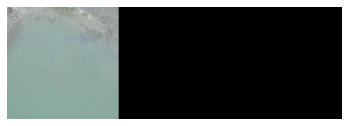

175/175 [==============================] - 138s 788ms/step - loss: 0.3668 - mean_iou: 0.0114 - val_loss: 0.3138 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 34/200
175/175 [==============================] - ETA: 0s - loss: 0.3537 - mean_iou: 0.0171i= 34 loss= 0.35367444157600403 val_loss= 0.31985288858413696 mean_iou= 0.017143363133072853 val_mean_iou= 0.0476190485060215
53.483246


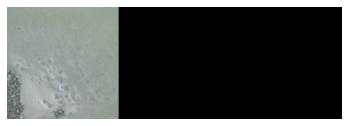

175/175 [==============================] - 139s 795ms/step - loss: 0.3537 - mean_iou: 0.0171 - val_loss: 0.3199 - val_mean_iou: 0.0476 - lr: 0.0010
Epoch 35/200
175/175 [==============================] - ETA: 0s - loss: 0.3667 - mean_iou: 0.0343i= 35 loss= 0.36673852801322937 val_loss= 0.3309704065322876 mean_iou= 0.03430010750889778 val_mean_iou= 0.0
46.051975


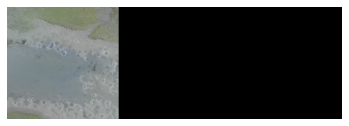

175/175 [==============================] - 140s 800ms/step - loss: 0.3667 - mean_iou: 0.0343 - val_loss: 0.3310 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 36/200
175/175 [==============================] - ETA: 0s - loss: 0.3604 - mean_iou: 0.0057i= 36 loss= 0.36044594645500183 val_loss= 0.34420204162597656 mean_iou= 0.005723228678107262 val_mean_iou= 0.0476190485060215
70.28526


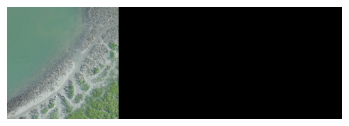

175/175 [==============================] - 140s 798ms/step - loss: 0.3604 - mean_iou: 0.0057 - val_loss: 0.3442 - val_mean_iou: 0.0476 - lr: 0.0010
Epoch 37/200
175/175 [==============================] - ETA: 0s - loss: 0.3680 - mean_iou: 0.0057i= 37 loss= 0.3679686188697815 val_loss= 0.3316623866558075 mean_iou= 0.005725801922380924 val_mean_iou= 3.488654692773707e-05
44.458344


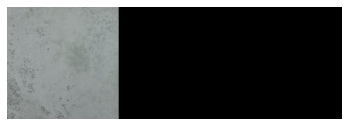

175/175 [==============================] - 140s 802ms/step - loss: 0.3680 - mean_iou: 0.0057 - val_loss: 0.3317 - val_mean_iou: 3.4887e-05 - lr: 0.0010
Epoch 38/200
175/175 [==============================] - ETA: 0s - loss: 0.3580 - mean_iou: 0.0229i= 38 loss= 0.35797855257987976 val_loss= 0.33769798278808594 mean_iou= 0.022857142612338066 val_mean_iou= 7.24135315977037e-05
42.84647


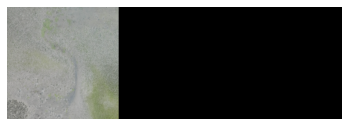

175/175 [==============================] - 141s 804ms/step - loss: 0.3580 - mean_iou: 0.0229 - val_loss: 0.3377 - val_mean_iou: 7.2414e-05 - lr: 0.0010
Epoch 39/200
175/175 [==============================] - ETA: 0s - loss: 0.3657 - mean_iou: 0.0171i= 39 loss= 0.36565443873405457 val_loss= 0.3554414212703705 mean_iou= 0.01714288629591465 val_mean_iou= 0.0
43.21649


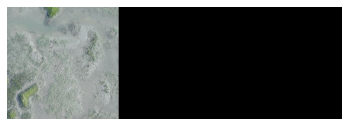

175/175 [==============================] - 141s 805ms/step - loss: 0.3657 - mean_iou: 0.0171 - val_loss: 0.3554 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 40/200
175/175 [==============================] - ETA: 0s - loss: 0.3635 - mean_iou: 0.0343i= 40 loss= 0.3634999096393585 val_loss= 0.3331587612628937 mean_iou= 0.0342857800424099 val_mean_iou= 0.0
69.62077


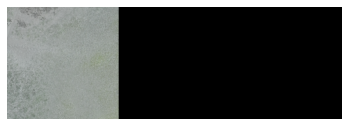

175/175 [==============================] - 143s 817ms/step - loss: 0.3635 - mean_iou: 0.0343 - val_loss: 0.3332 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 41/200
175/175 [==============================] - ETA: 0s - loss: 0.3582 - mean_iou: 0.0343i= 41 loss= 0.358161598443985 val_loss= 0.3156559467315674 mean_iou= 0.034285712987184525 val_mean_iou= 0.0
72.7337


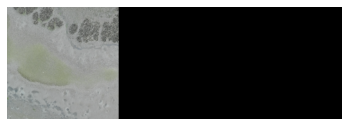

175/175 [==============================] - 144s 821ms/step - loss: 0.3582 - mean_iou: 0.0343 - val_loss: 0.3157 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 42/200
175/175 [==============================] - ETA: 0s - loss: 0.3736 - mean_iou: 0.0460i= 42 loss= 0.3735659122467041 val_loss= 0.298168420791626 mean_iou= 0.04602060467004776 val_mean_iou= 0.0476190485060215
42.04227


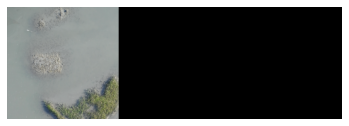

175/175 [==============================] - 143s 817ms/step - loss: 0.3736 - mean_iou: 0.0460 - val_loss: 0.2982 - val_mean_iou: 0.0476 - lr: 0.0010
Epoch 43/200
175/175 [==============================] - ETA: 0s - loss: 0.3582 - mean_iou: 0.0114i= 43 loss= 0.3582295775413513 val_loss= 0.3362172245979309 mean_iou= 0.011437118984758854 val_mean_iou= 0.0476190485060215
46.478672


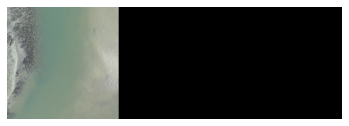

175/175 [==============================] - 142s 811ms/step - loss: 0.3582 - mean_iou: 0.0114 - val_loss: 0.3362 - val_mean_iou: 0.0476 - lr: 0.0010
Epoch 44/200
175/175 [==============================] - ETA: 0s - loss: 0.3729 - mean_iou: 0.0172i= 44 loss= 0.3729453384876251 val_loss= 0.3180989921092987 mean_iou= 0.01715298928320408 val_mean_iou= 0.0
47.446228


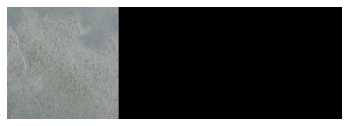

175/175 [==============================] - 141s 808ms/step - loss: 0.3729 - mean_iou: 0.0172 - val_loss: 0.3181 - val_mean_iou: 0.0000e+00 - lr: 0.0010
Epoch 45/200
175/175 [==============================] - ETA: 0s - loss: 0.3521 - mean_iou: 0.0114
Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
i= 45 loss= 0.3520777225494385 val_loss= 0.3412064015865326 mean_iou= 0.011431786231696606 val_mean_iou= 0.0
71.35804


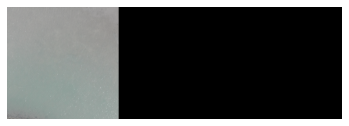

175/175 [==============================] - 141s 804ms/step - loss: 0.3521 - mean_iou: 0.0114 - val_loss: 0.3412 - val_mean_iou: 0.0000e+00 - lr: 0.0010


In [0]:
hist = model.fit(train_generator, 
                epochs = max_epochs, steps_per_epoch = train_steps,
                validation_data = val_generator, validation_steps = val_steps,
                callbacks = build_callbacks(filepath, min_delta, min_lr, factor, patience, cooldown))	

In the above, we gave an output variable to the `.fit()` command. This contains the training histories. That is, losses and metrics as a function of epoch. You can access the variables in the dictionary like so

#### Plot the training history

In [0]:
hist['history'].keys()

dict_keys(['loss', 'mean_iou', 'val_loss', 'val_mean_iou', 'lr'])

Let's make a plot of the histories of both train and validation losses and dice coefficients, and also the history of the learning rate

Text(0, 0.5, 'Learning rate')

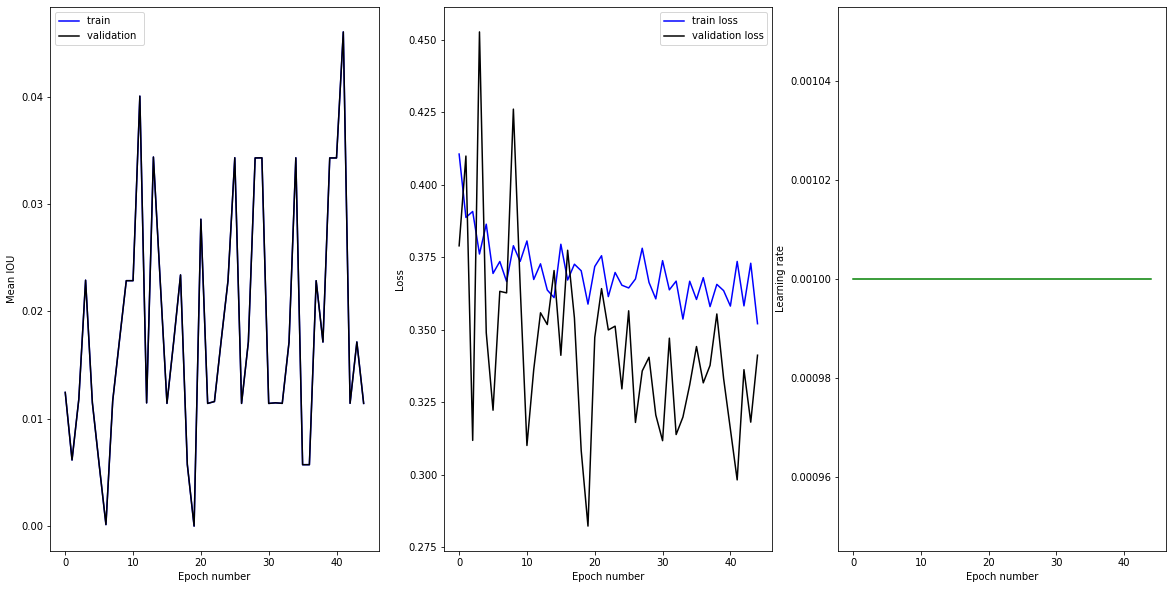

In [0]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.plot(hist['history']['mean_iou'], 'b', label='train ')
plt.plot(hist['history']['val_mean_iou'], 'k', label='validation ')
plt.xlabel('Epoch number'); plt.ylabel('Mean IOU')
plt.legend()

plt.subplot(132)
plt.plot(hist['history']['loss'], 'b', label='train loss')
plt.plot(hist['history']['val_loss'], 'k', label='validation loss')
plt.xlabel('Epoch number'); plt.ylabel('Loss')
plt.legend()

plt.subplot(133)
plt.plot(hist['history']['lr'], 'g')
plt.xlabel('Epoch number'); plt.ylabel('Learning rate')

Pretty bad! Why is that?

We used a metric that isn't very good for class imbalanced problems. This is a situation where the number of reef pixels is far fewer than the non-reef pixels

This demonstrates - the hard way - why you need to use a loss function that is more suitable for a class-imbalanced binary segmentation


How do we do better? Let's explore in the next tutorial, when we use a Dice coefficient and Dice loss on the same data and the same model, and this time acheive a much better result


This jupyter notebook running on Google Colab is part of the "Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning" course. The main course website can be accessed [here](https://mardascience.gitlab.io/binary_image_segmentation_for_geosciences/#/)